In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sympy as sym
import astropy.constants as const
from astropy import units as u
from astropy.modeling.blackbody import blackbody_nu
from scipy.optimize import fsolve
import pdb
%matplotlib inline

# Code without Full SED

[5.30371676e+12 5.27005880e+12 5.43696677e+12]
[5.14854109e+30 5.21042731e+31 1.53033019e+32]


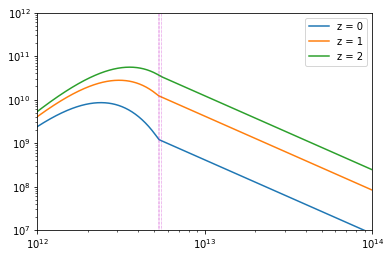

In [36]:
def blackbody(v, T):
    #Gives a blackbody spectrum as a function of frequency and temperature
    
    # Defining physical constants
    c = const.c.cgs.value
    h = const.h.cgs.value
    k_B = const.k_B.cgs.value
    
    return (2.0*h/c**2) * v**3 / (np.exp((v/T) * (h/k_B)) - 1.0)

def boltzmann(x, T):
    # Returns the Boltzmann factor for a given temperature and x
    
    # Defining physical constants
    c = const.c.cgs.value
    h = const.h.cgs.value
    k_B = const.k_B.cgs.value
    
    return np.exp(h*x / (k_B*T))

def sed(nu_obs, z, beta=1.6, alpha=0.2):
    #Undoing Redshift: from Observing to Original
    nu = nu_obs * (1+z)
    temp_obs = 20.7                        # effective dust temperature at z=0
    temp_array = temp_obs * (1+z)**alpha
    
    return nu * blackbody(nu, temp_array)

def phi(z, delta=2.4):
    # Redshift dependent global normalization
    return (1+z)**delta

def sigma(M,z):
    #Halo mass dependance of glaxy luminosity
    
    logM_eff = 12.3  # M_eff = log10(mass peak of specific IR emissivity) in solar masses
    sigma = 0.3      # standard deviation of the Gaussian
    
    return M/np.sqrt(2*np.pi*sigma**2) * np.exp(- (np.log10(M)-logM_eff)**2 / (2*sigma**2))
    
def luminosity(M, z, v_obs):
    return L_o * sigma(M,z) * phi(z) * sed(v_obs, z)
    
#Input data    
nu_obs = np.array([353.0e9])
redshifts = np.array([0, 1, 2])

#Run the code
luminosity(M, redshifts, nu_obs)

# The Full SED

[5.30371676e+12 5.27005880e+12 5.43696677e+12]
[5.14854109e+30 5.21042731e+31 1.53033019e+32]


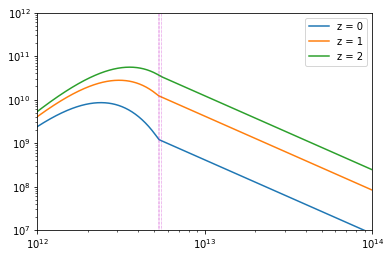

In [36]:
def blackbody(v, T):
    # Defining physical constants
    c = const.c.cgs.value
    h = const.h.cgs.value
    k_B = const.k_B.cgs.value
    
    return (2.0*h/c**2) * v**3 / (np.exp((v/T) * (h/k_B)) - 1.0)

def boltzmann(x, T):
    # Defining physical constants
    c = const.c.cgs.value
    h = const.h.cgs.value
    k_B = const.k_B.cgs.value
    
    return np.exp(h*x / (k_B*T))

def deriv_cond(v, T, b, g):
    # Defining physical constants
    c = const.c.cgs.value
    h = const.h.cgs.value
    k_B = const.k_B.cgs.value
    
    v_star = 1.0e12
    
    first_term = (b+3) * v**(b+2) / (boltzmann(v,T) - 1)
    second_term = - (h/(k_B*T)) * boltzmann(v,T) * v**(b+3) / (boltzmann(v,T) - 1)**2
    third_term = -g
    
    return ((v)**(1-b)/blackbody(v,T)) * (2.0*h/c**2) * (first_term + second_term) + third_term

def sysEquations(var, *constants):
    temps, b, g = constants  
    vo_g = var[:temps.size]
    A_g = var[temps.size:]
    
    v_star = 1.0e12
    
    eq1 = (vo_g)**b * blackbody(vo_g, temps) - A_g * (vo_g)**(-g)
    eq2 = deriv_cond(vo_g, temps, b, g)
    
    return np.concatenate((eq1, eq2))

def sed(nu_obs, z, plot=False, beta=1.75, gamma=1.7, alpha=0.36):
    #Undoing Redshift: from Observing to Original
    nu = nu_obs * (1+z)
    temp_obs = 24.4
    temp_array = temp_obs * (1+z)**alpha
    
    #Get nu_o and proportionality constant
    v_star = 1.0e12
    nu_o_guess = np.ones(temp_array.shape, dtype=np.float64) * 7e12#/v_star
    A_guess = np.ones(temp_array.shape, dtype=np.float64) * 1e24
    #pdb.set_trace()
    sol = fsolve(sysEquations, np.concatenate((nu_o_guess, A_guess)), args=(temp_array, beta, gamma))
    nu_o_array = sol[:temp_array.size]
    A_array = sol[temp_array.size:]
    
    #Plot the whole spectrum
    print(nu_o_array)
    print(A_array)
    if plot:
        nu_range = np.logspace(9, 14, 2000)
        for i, nu_o in enumerate(nu_o_array):
            #Calculation
            spectrum = np.where(nu_range<nu_o, (nu_range**beta)*blackbody(nu_range, temp_array[i]), A_array[i]*nu_range**(-gamma))
            
            #Plot curves
            #plt.figure()
            plt.plot(nu_range, spectrum, label='{} {}'.format("z =", z[i]))
            #plt.plot(nu_range, blackbody_nu(nu_range, temp_array[i]), label='{} {}'.format("BB for z =", z[i]))
            
            #Marking v_o on the graph
            plt.axvline(x = nu_o, ls=':', color='m', lw=0.5)
            
            #result = np.where(abs(nu_range - nu_o) < 1e10)[0][0]         
            #plt.Circle((nu_o, spectrum[result]), 2e12, color='r')
            #pdb.set_trace()
            
            #Plot Properties
            plt.xscale('log')
            plt.yscale('log')
            plt.ylim([1e7, 1e12])
            plt.xlim([1e12, 1e14])
            plt.legend()
            
nu_obs = np.array([353.0e9])
redshifts = np.array([0, 1, 2])
sed(nu_obs, redshifts, plot=True)

# Testing Guesses

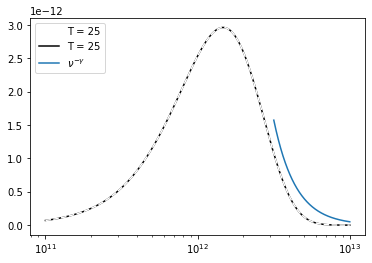

In [85]:
def sed(beta=1.75, gamma=1.7, alpha=0.36):

    # Defining physical constants
    c = const.c.cgs.value
    h = const.h.cgs.value
    k_B = const.k_B.cgs.value
    
    # Undoing Redshift: from Observing to Original
    nu_o = nu_obs * (1+z)
    temp_obs = 24.4
    temp_o = temp_obs * (1+z)**alpha
    
    #get temperature in nu_o for the sympy
    
    #Find the nu_o
    sym.var('v T A', real=True)
    blackbody = (2*const.h.cgs.value/const.c.cgs.value**2) * v**3 / (sym.exp((v/T) * (const.h.cgs.value/const.k_B.cgs.value)) - 1)
    eq1 = v**beta * blackbody - A*v**(-gamma)
    n = 1
    eq2 = (sym.diff(eq1, v)).subs(v, n)
    
    
    return eq1, eq2

nu = np.logspace(11, 13, 2000)
# bb = (2*const.h.cgs.value/const.c.cgs.value**2) * (nu)**3 / (np.exp((nu/T) * (const.h.cgs.value/const.k_B.cgs.value)) - 1)
# plt.plot(nu, bb, label='mine')
plt.plot(nu, blackbody_nu(nu, 25), 'w--', zorder=2,label='T = 25')
plt.plot(nu, blackbody(nu, 25), 'k', zorder=1, label='T = 25')
#plt.plot(nu, blackbody_nu(nu, 300), label='300')
#plt.plot(nu, blackbody_nu(nu, 500), label='500')
plt.plot(nu[1500:], 5e25 *nu[1500:]**-3, label=r'$\nu^{-\gamma}$')

plt.xscale('log')
plt.legend(loc='upper left');


# Troubleshooting

In [51]:
def blackbody(v, T):
    # Defining physical constants
    c = const.c.cgs.value
    h = const.h.cgs.value
    k_B = const.k_B.cgs.value
    
    return (2.0*h/c**2) * v**3 / (np.exp((v/T) * (h/k_B)) - 1.0)

def deriv_cond(v, A, T, b, g):
    # Defining physical constants
    c = const.c.cgs.value
    h = const.h.cgs.value
    k_B = const.k_B.cgs.value
    
    first_term = ((3.0+b) * v**(2.0+b)) / (np.exp(h*v/(k_B*T)) - 1.0)
    second_term = (v**(3.0+b) * (h/(k_B*T)) * np.exp(h*v/(k_B*T)))  /  (np.exp(h*v/(k_B*T)) - 1.0)**2 
    third_term = A * g * v**(-g - 1.0)
    
    return (2.0*h/c**2) * (first_term - second_term + third_term)

def sysEquations(var, *constants):
    temps, b, g = constants  
    vo_g, A_g = var
    
    eq1 = vo_g**b * blackbody(vo_g, temps) - A_g * vo_g**(-g)
    eq2 = deriv_cond(vo_g, A_g, temps, b, g)
    
    return (eq1, eq2)

def sed(nu_obs, z, plot=False, beta=1.75, gamma=1.7, alpha=0.36):
    #Undoing Redshift: from Observing to Original
    nu = nu_obs * (1+z)
    temp_obs = 24.4
    temp_array = temp_obs * (1+z)**alpha
    
    #Get nu_o and proportionality constant
    #nu_o_guess = np.ones(temp_array.shape, dtype=np.float64) * 2e12
    #A_guess = np.ones(temp_array.shape, dtype=np.float64) * 1e20
    #pdb.set_trace()
    sol = fsolve(sysEquations, (7e12, 1e24), args=(temp_array, beta, gamma))
    
    return sol
    
v, A = sed(1e9, 0.0)
print(v, A)
print(sysEquations( (v,A), 24.4, beta, gamma) )

16617848685450.912 1.7625055981387392e+24
(3.90087961932295e-12, -9.925175377942685e-11)


In [ ]:
from scipy.optimize import fsolve
def equations(z):
    v, t = z
    
    return (v+t**2-4, sym.exp(v) + v*t - 3)

sol = fsolve(equations, (1,1))
print(sol)
print(equations(sol))

In [23]:
x = np.arange(10)
np.where(x>4, x*5, x)

array([ 0,  1,  2,  3,  4, 25, 30, 35, 40, 45])